In [1]:
import numpy as np
import torch
import deeplay as dl
import torchvision
import PIL
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import os



In [2]:

def read_mnist_txt(file_path):
    """Read MNIST-like data from text file"""
    images = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split()
            image_num = parts[0].strip('"')
            label = int(parts[1])
            
            # Validate label range
            if label < -9 or label > 9:
                raise ValueError(f"Invalid label {label} found in the dataset.")
            
            pixels = list(map(float, parts[2:]))
            pixel_array = np.array(pixels).reshape(16, 16)
            images.append(pixel_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
#random forest for cross-validation
from sklearn.metrics import accuracy_score

def train_RandomForest(trainingSet, trainingLabels, n_estimators=100):
    """Train Random Forest classifier and return the trained model"""
    # Flatten images to 1D arrays
    X_train = [img.flatten() for img in trainingSet]
    
    # Initialize and train Random Forest
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, trainingLabels)
    
    return rf

def predict_with_RandomForest(model, testSet):
    """Make predictions using trained Random Forest model"""
    # Flatten test images to 1D arrays
    X_test = [img.flatten() for img in testSet]
    
    # Return predictions
    return model.predict(X_test)

def randomForestClassifier(trainingSet, trainingLabels, testSet, n_estimators=100):
    """Original function maintained for backward compatibility"""
    rf = train_RandomForest(trainingSet, trainingLabels, n_estimators)
    return predict_with_RandomForest(rf, testSet)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate(random_state, images, labels, train_fn, predict_fn, k_folds=5, metric_fn=accuracy_score):
   
    all_scores = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = random_state)

    for fold, (train_idx, val_idx) in enumerate(kf.split(images)):

        train_images, val_images = images[train_idx], images[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Train and predict
        model = train_fn(train_images, train_labels)
        predictions = predict_fn(model, val_images)

        # Score
        score = metric_fn(val_labels, predictions)
        all_scores.append(score)

    return all_scores


Testing n_estimators = 5
Fold 1 Score: 0.8225
Fold 2 Score: 0.8350
Fold 3 Score: 0.8675
Fold 4 Score: 0.8850
Fold 5 Score: 0.8000
Testing n_estimators = 10
Fold 1 Score: 0.8750
Fold 2 Score: 0.8725
Fold 3 Score: 0.9125
Fold 4 Score: 0.9125
Fold 5 Score: 0.8750
Testing n_estimators = 20
Fold 1 Score: 0.9125
Fold 2 Score: 0.9100
Fold 3 Score: 0.9250
Fold 4 Score: 0.9425
Fold 5 Score: 0.9075
Testing n_estimators = 50
Fold 1 Score: 0.9150
Fold 2 Score: 0.9250
Fold 3 Score: 0.9375
Fold 4 Score: 0.9500
Fold 5 Score: 0.9350
Testing n_estimators = 100
Fold 1 Score: 0.9225
Fold 2 Score: 0.9250
Fold 3 Score: 0.9350
Fold 4 Score: 0.9475
Fold 5 Score: 0.9425
Testing n_estimators = 150
Fold 1 Score: 0.9325
Fold 2 Score: 0.9275
Fold 3 Score: 0.9325
Fold 4 Score: 0.9500
Fold 5 Score: 0.9400
Testing n_estimators = 200
Fold 1 Score: 0.9275
Fold 2 Score: 0.9275
Fold 3 Score: 0.9350
Fold 4 Score: 0.9450
Fold 5 Score: 0.9450
Testing n_estimators = 400
Fold 1 Score: 0.9300
Fold 2 Score: 0.9300
Fold 3 Score

C:\Users\Nils\AppData\Local\Temp\ipykernel_8588\3323805071.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(rf_errors_boxplot, labels=[str(n) for n in estimator_values], patch_artist=True)


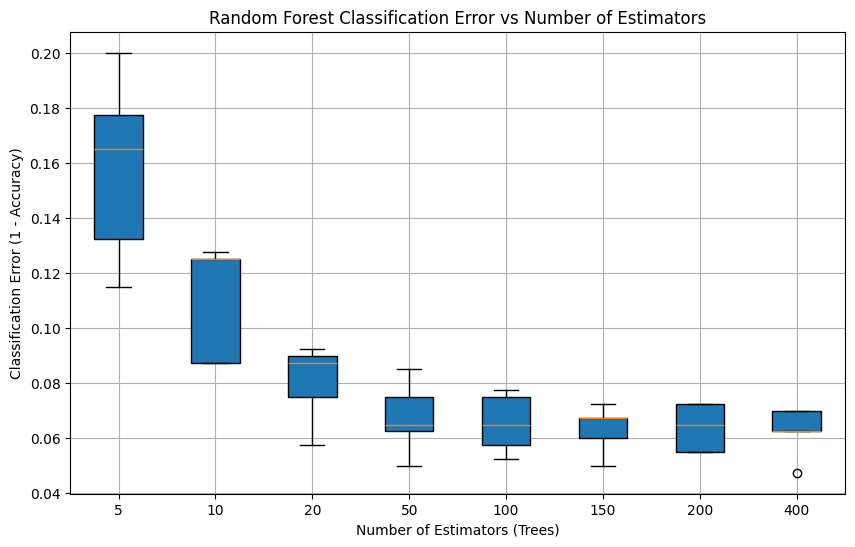

In [7]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

images, labels = read_mnist_txt("Numbers.txt")
flat_images = images.reshape(len(images), -1)
flat_images = StandardScaler().fit_transform(flat_images)

estimator_values = [5, 10, 20, 50, 100, 150, 200, 400]
repeats = 1
all_results = []

for n in estimator_values:
    print(f"Testing n_estimators = {n}")
    scores_n = []

    def train_rf(X, y): return RandomForestClassifier(n_estimators=n, random_state=42).fit(X, y)
    def predict_rf(model, X): return model.predict(X)

    for rep in range(repeats):
        scores = cross_validate(
            random_state=42 + rep,
            images=flat_images,
            labels=labels,
            train_fn=train_rf,
            predict_fn=predict_rf,
            k_folds=5,
            metric_fn=accuracy_score
        )
        scores_n.extend(scores)

    all_results.append(scores_n)

# Convert accuracy scores to error for plotting
rf_errors_boxplot = [[1 - s for s in scores] for scores in all_results]

plt.figure(figsize=(10, 6))
plt.boxplot(rf_errors_boxplot, labels=[str(n) for n in estimator_values], patch_artist=True)
plt.title("Random Forest Classification Error vs Number of Estimators")
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.grid(True)
plt.show()
